(625, 25)
(15625, 1)
(15625, 1)
(15625, 1)
(15625, 1)
(15625, 1)
(15625, 1)


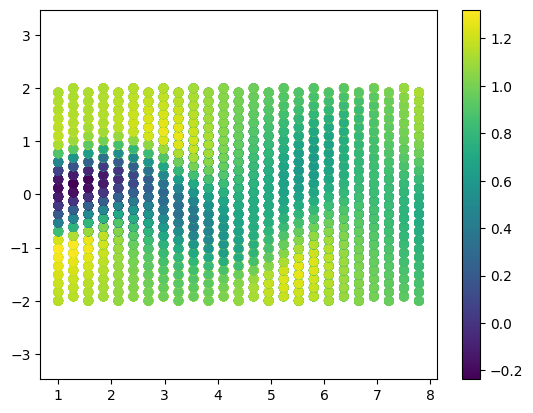

In [1]:
import numpy as np
import scipy.io
# Load Data
data = scipy.io.loadmat('cylinder_nektar_wake.mat')
        
U_star = data['U_star'] # N x 2 x T
P_star = data['p_star'] # N x T
t_star = data['t'] # T x 1
X_star = data['X_star'] # N x 2

N = X_star.shape[0]
T = t_star.shape[0]

# Rearrange Data 
XX = np.tile(X_star[:,0:1], (1,T)) # N x T
YY = np.tile(X_star[:,1:2], (1,T)) # N x T
TT = np.tile(t_star, (1,N)).T # N x T

UU = U_star[:,0,:] # N x T
VV = U_star[:,1,:] # N x T
PP = P_star # N x T

# Take every 4th of XX, YY, TT, UU, VV, PP
step = 8
XX = XX[::step,::step]
YY = YY[::step,::step]
TT = TT[::step,::step]
UU = UU[::step,::step]
VV = VV[::step,::step]
PP = PP[::step,::step]

print(XX.shape)

x = XX.flatten()[:,None] # NT x 1
y = YY.flatten()[:,None] # NT x 1
t = TT.flatten()[:,None] # NT x 1

u = UU.flatten()[:,None] # NT x 1
v = VV.flatten()[:,None] # NT x 1
p = PP.flatten()[:,None] # NT x 1

# Print the shape of the data
print(x.shape)
print(y.shape)
print(t.shape)
print(u.shape)
print(v.shape)
print(p.shape)

# Plot scatter of x y u
import matplotlib.pyplot as plt
plt.scatter(x, y, c=u)
plt.colorbar()
plt.axis('equal')
plt.show()

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time

def NN(layers):
    model = tf.keras.Sequential()
    for i in range(len(layers)-1):
        activation = 'tanh' if i < len(layers)-2 else 'linear'
        model.add(tf.keras.layers.Dense(layers[i+1], input_shape=(layers[i],), activation=activation))
    return model

no_of_neurons = 40
layers = [3, no_of_neurons, no_of_neurons, no_of_neurons, no_of_neurons, no_of_neurons, no_of_neurons, no_of_neurons, 3]

model = NN(layers)

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

model.summary()
print("Number of layers: ", len(model.layers))
# Print input and output shapes
print('x:', x.shape)
print('y:', y.shape)
print('t:', t.shape)
print('u:', u.shape)
print('v:', v.shape)
print('p:', p.shape)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 40)                160       
                                                                 
 dense_1 (Dense)             (None, 40)                1640      
                                                                 
 dense_2 (Dense)             (None, 40)                1640      
                                                                 
 dense_3 (Dense)             (None, 40)                1640      
                                                                 
 dense_4 (Dense)             (None, 40)                1640      
                                                                 
 dense_5 (Dense)             (None, 40)                1640      
                                                                 
 dense_6 (Dense)             (None, 40)                1

In [3]:
# Create boundary points for x and y in 2D from 0 to max value
x_boundary = np.array([min(x), max(x), min(x), max(x)]).reshape(-1, 1)
y_boundary = np.array([min(y), min(y), max(y), max(y)]).reshape(-1, 1)

# Create boundary values using Dirichlet boundary conditions
u_boundary = np.array([0, 0, 1, 0]).reshape(-1, 1)
v_boundary = np.array([0, 0, 0, 0]).reshape(-1, 1)
p_boundary = np.array([0, 0, 0, 0]).reshape(-1, 1)

# Boundary data
boundary_data = np.concatenate([x_boundary, y_boundary, u_boundary, v_boundary, p_boundary], axis=1)

print(boundary_data)

[[ 1.         -2.          0.          0.          0.        ]
 [ 7.78787879 -2.          0.          0.          0.        ]
 [ 1.          2.          1.          0.          0.        ]
 [ 7.78787879  2.          0.          0.          0.        ]]


In [4]:
# Create a PINN loss function

def f_model(input_data, model):
    # Compute gradients
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(input_data)
        x = input_data[:,0:1]
        y = input_data[:,1:2]
        t = input_data[:,2:3]

        u = model(input_data)[:,0:1]
        v = model(input_data)[:,1:2]
        p = model(input_data)[:,2:3]

        u = model(tf.concat([x,y,t], axis=1))[:,0:1]
        v = model(tf.concat([x,y,t], axis=1))[:,1:2]
        p = model(tf.concat([x,y,t], axis=1))[:,2:3]

        # Convert u v p to float64
        u = tf.cast(u, tf.float64)
        v = tf.cast(v, tf.float64)
        p = tf.cast(p, tf.float64)

        '''print(x.dtype)
        print(y.dtype)
        print(t.dtype)
        print(u.dtype)
        print(v.dtype)
        print(p.dtype)'''
        
    u_x = tape.gradient(u, x)
    v_x = tape.gradient(v, x)
    p_x = tape.gradient(p, x)
    u_y = tape.gradient(u, y)
    v_y = tape.gradient(v, y)
    p_y = tape.gradient(p, y)
    u_t = tape.gradient(u, t)
    v_t = tape.gradient(v, t)
    p_t = tape.gradient(p, t)

    
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(x)
        tape.watch(y)
        u_xx = tape.gradient(u_x, x)
        v_xx = tape.gradient(v_x, x)
        p_xx = tape.gradient(p_x, x)
        u_yy = tape.gradient(u_y, y)
        v_yy = tape.gradient(v_y, y)
        p_yy = tape.gradient(p_y, y)

    u_xx = tape.gradient(u_x, x)
    v_xx = tape.gradient(v_x, x)
    p_xx = tape.gradient(p_x, x)
    u_yy = tape.gradient(u_y, y)
    v_yy = tape.gradient(v_y, y)
    p_yy = tape.gradient(p_y, y)
    
    del tape
    # Compute residual
    f_u = u_t + u*u_x + v*u_y + p_x #- 1/500*(u_xx + u_yy)
    f_v = v_t + u*v_x + v*v_y + p_y #- 1/500*(v_xx + v_yy)
    f_p = u_x + v_y
    return f_u, f_v, f_p

In [5]:
def f_model(input_data, model):
    # Compute gradients
    with tf.GradientTape(persistent=True) as tape2:
        tape2.watch(input_data) 
        with tf.GradientTape(persistent=True) as tape:
            tape.watch(input_data)
            x = input_data[:,0:1]
            y = input_data[:,1:2]
            t = input_data[:,2:3]

            u = model(input_data)[:,0:1]
            v = model(input_data)[:,1:2]
            p = model(input_data)[:,2:3]

            u = model(tf.concat([x,y,t], axis=1))[:,0:1]
            v = model(tf.concat([x,y,t], axis=1))[:,1:2]
            p = model(tf.concat([x,y,t], axis=1))[:,2:3]

            # Convert u v p to float64
            u = tf.cast(u, tf.float64)
            v = tf.cast(v, tf.float64)
            p = tf.cast(p, tf.float64)
            
        # 1st order
        u_x = tape.gradient(u, x)
        v_x = tape.gradient(v, x)
        p_x = tape.gradient(p, x)
        u_y = tape.gradient(u, y)
        v_y = tape.gradient(v, y)
        p_y = tape.gradient(p, y)
        u_t = tape.gradient(u, t)
        v_t = tape.gradient(v, t)
        p_t = tape.gradient(p, t)
    
    # 2nd order
    u_xx = tape2.gradient(u_x, x)
    v_xx = tape2.gradient(v_x, x)
    p_xx = tape2.gradient(p_x, x)
    u_yy = tape2.gradient(u_y, y)
    v_yy = tape2.gradient(v_y, y)
    p_yy = tape2.gradient(p_y, y)
    
    # Compute residual
    f_u = u_t + u*u_x + v*u_y + p_x - 1/500*(u_xx + u_yy)
    f_v = v_t + u*v_x + v*v_y + p_y - 1/500*(v_xx + v_yy)
    f_p = u_x + v_y

    return f_u, f_v, f_p

In [6]:
# Inputs and outputs
input_data = [x, y, t]
output_data = [u, v, p]
# Tensor
input_data = tf.concat(input_data, 1)
output_data = tf.concat(output_data, 1)

duration = 0
total_time = []

def train(model, input_data, output_data, f_model, epochs):
    # Train
    for epoch in range(epochs):
        with tf.GradientTape() as tape:
            # Make predictions
            predictions = model(input_data)
            # Convert predictions to float64
            predictions = tf.cast(predictions, tf.float64)
            output_data = tf.cast(output_data, tf.float64)
            '''# Print shape of predictions and output_data
            print('predictions:', predictions.shape)
            print('output_data:', output_data.shape)
            # And type
            print('predictions:', predictions.dtype)
            print('output_data:', output_data.dtype)'''
            # Compute loss
            loss = tf.reduce_mean(tf.square(output_data - predictions))
            # Compute residual
            f_u, f_v, f_p = f_model(input_data, model)
            loss += tf.reduce_mean(tf.square(f_u)) + tf.reduce_mean(tf.square(f_v)) + tf.reduce_mean(tf.square(f_p))
            # Mathematically: loss = ||u-u_true||^2 + ||v-v_true||^2 + ||p-p_true||^2 + ||f_u||^2 + ||f_v||^2 + ||f_p||^2
        # Compute gradients
        gradients = tape.gradient(loss, model.trainable_variables)
        # Update weights
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))     

        # Print loss
        if epoch % 1 == 0:
            print("Epoch: ", epoch, "Loss: ", loss.numpy())

        # Collect loss for plotting loss curve
        losses.append(loss.numpy())

        # Calculate elapsed time for each epoch
        duration = time.time() - start_time
        #print('Time elapsed: ', duration)
        # Add duration to total_time list
        total_time.append(duration)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
epochs = 40000
start_time = time.time()
losses = []
with tf.device('/GPU:0'):
    train(model, input_data, output_data, f_model, epochs)
print("Training time: ", time.time() - start_time) #20mins

Epoch:  0 Loss:  0.4799389443253825
Epoch:  1 Loss:  0.2719593383763963
Epoch:  2 Loss:  0.15046488513326628
Epoch:  3 Loss:  0.09792856529515273
Epoch:  4 Loss:  0.08859969574559347
Epoch:  5 Loss:  0.09657987051160113
Epoch:  6 Loss:  0.1052664346628223
Epoch:  7 Loss:  0.10763015456974802
Epoch:  8 Loss:  0.10254134357324425
Epoch:  9 Loss:  0.0925834619822413
Epoch:  10 Loss:  0.08201632431839567
Epoch:  11 Loss:  0.07470335958969986
Epoch:  12 Loss:  0.0725390983507063
Epoch:  13 Loss:  0.07468538792711277
Epoch:  14 Loss:  0.07819260527018679
Epoch:  15 Loss:  0.0799707819960231
Epoch:  16 Loss:  0.07857965215443406
Epoch:  17 Loss:  0.07451838197525575
Epoch:  18 Loss:  0.06938398527702515
Epoch:  19 Loss:  0.06485473511966376
Epoch:  20 Loss:  0.06202051420845079
Epoch:  21 Loss:  0.06115707385083822
Epoch:  22 Loss:  0.061846853625719525
Epoch:  23 Loss:  0.06328851884582228
Epoch:  24 Loss:  0.06464419769699946
Epoch:  25 Loss:  0.06531465214576657
Epoch:  26 Loss:  0.0650769

KeyboardInterrupt: 

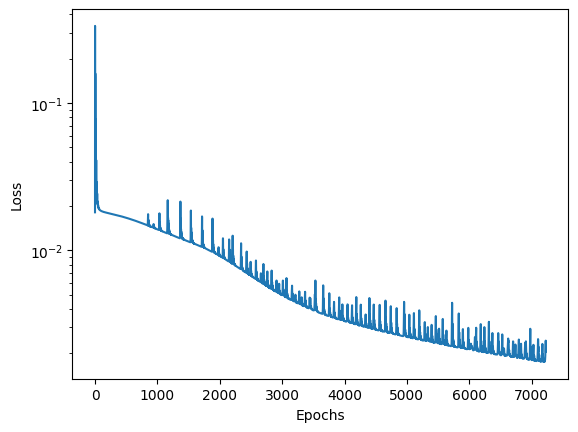

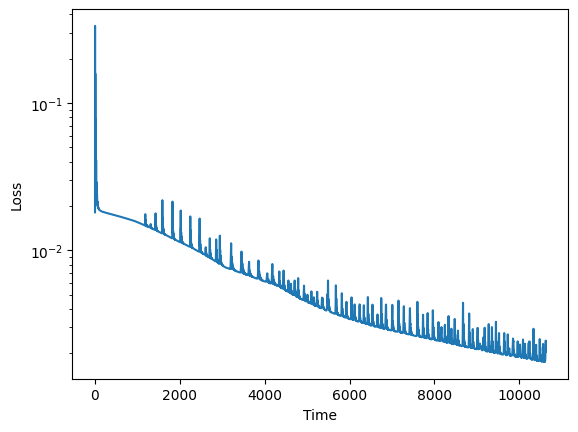

In [18]:
# Plot loss curve
plt.plot(losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.yscale('log')
plt.show()

# Plot total time
plt.plot(total_time, losses)
plt.xlabel('Time')
plt.ylabel('Loss')
plt.yscale('log')
plt.show()

In [19]:
# Plot predictions
predictions = model(input_data)
predictions = predictions.numpy()
print(predictions.shape)
u_pred = predictions[:,0]
v_pred = predictions[:,1]
p_pred = predictions[:,2]

# Reshape u_pred, v_pred, p_pred to N x T with the steps
u_pred = u_pred.reshape(XX.shape)
v_pred = v_pred.reshape(XX.shape)
p_pred = p_pred.reshape(XX.shape)

timestep = 0

# Print RMSE
RMSE_u = np.sqrt(np.mean((UU - u_pred)**2))
RMSE_v = np.sqrt(np.mean((VV - v_pred)**2))
RMSE_p = np.sqrt(np.mean((PP - p_pred)**2))

print('RMSE u: ', RMSE_u)
print('RMSE v: ', RMSE_v)
print('RMSE p: ', RMSE_p)

# Print L2 norm
L2_u = np.sqrt(np.sum((UU - u_pred)**2)/np.sum(UU**2))
L2_v = np.sqrt(np.sum((VV - v_pred)**2)/np.sum(VV**2))
L2_p = np.sqrt(np.sum((PP - p_pred)**2)/np.sum(PP**2))

print('L2 u: ', L2_u)
print('L2 v: ', L2_v)
print('L2 p: ', L2_p)

print("No boundary conditions are applied")
print("No initial conditions are applied")

(15625, 3)
RMSE u:  0.03824453421216609
RMSE v:  0.03441717912580111
RMSE p:  0.01571934398635459
L2 u:  0.04217974974631115
L2 v:  0.12642217919565354
L2 p:  0.11607795299856863
No boundary conditions are applied
No initial conditions are applied


C:\Users\User\AppData\Local\Temp\ipykernel_20248\1587010859.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
C:\Users\User\AppData\Local\Temp\ipykernel_20248\1587010859.py:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
C:\Users\User\AppData\Local\Temp\ipykernel_20248\1587010859.py:21: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


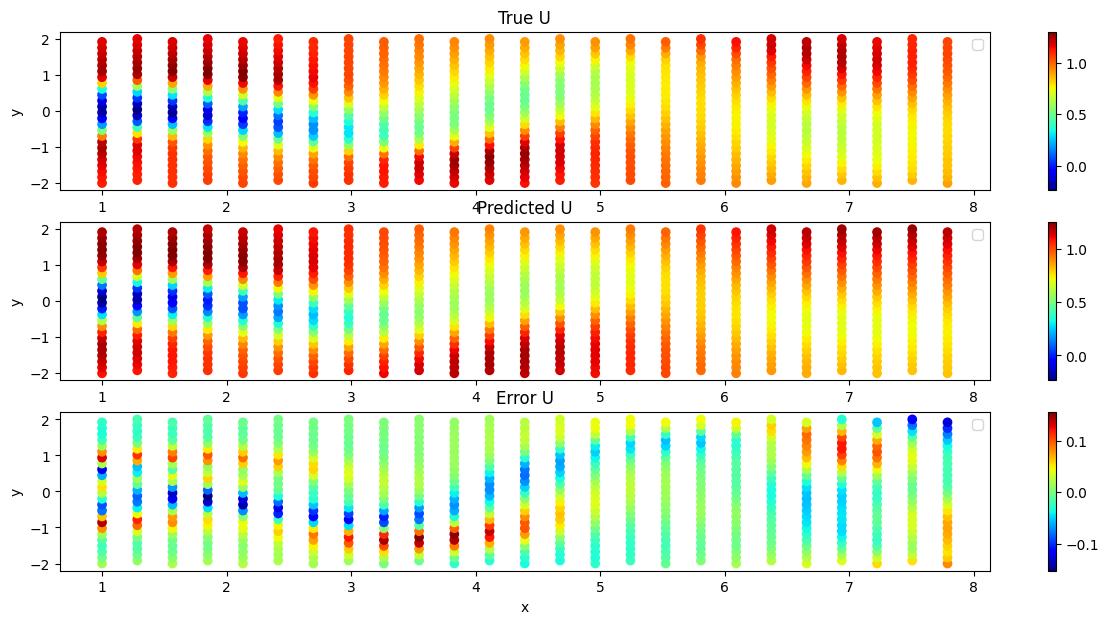

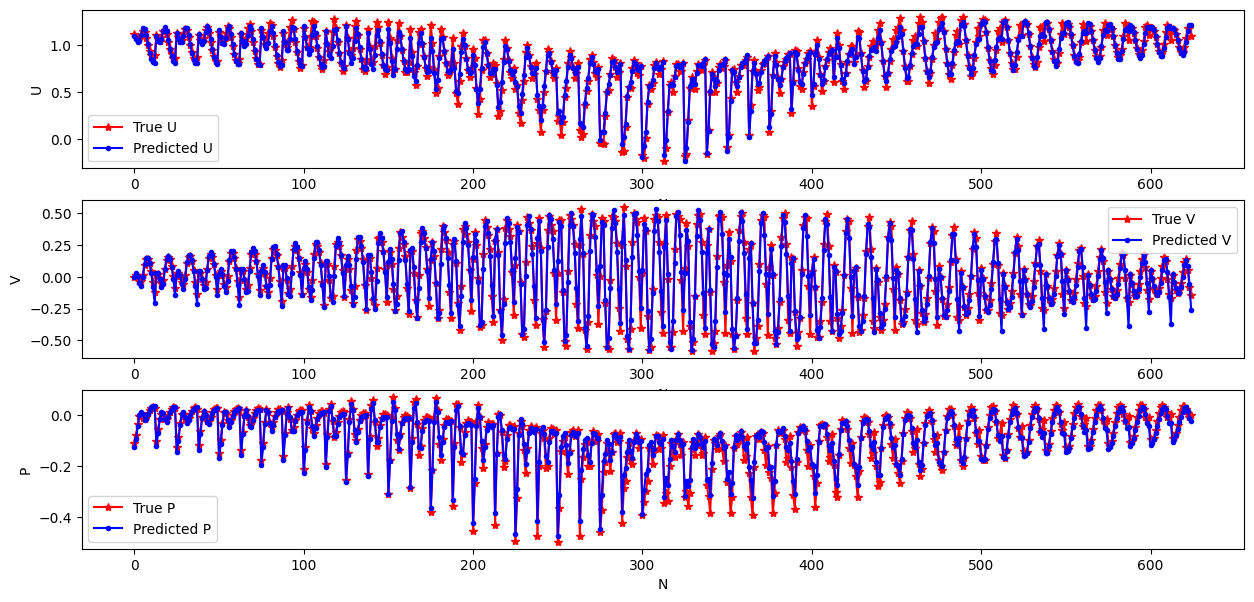

In [20]:
timestep = 0

plt.figure(figsize=(15, 7))
plt.subplot(3, 1, 1)
plt.scatter(XX[:, timestep], YY[:, timestep], c=UU[:, timestep], cmap='jet')
plt.colorbar()
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.title('True U')
plt.subplot(3, 1, 2)
plt.scatter(XX[:, timestep], YY[:, timestep], c=u_pred[:, timestep], cmap='jet')
plt.colorbar()
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.title('Predicted U')
plt.subplot(3, 1, 3)
plt.scatter(XX[:, timestep], YY[:, timestep], c=UU[:, timestep] - u_pred[:, timestep], cmap='jet')
plt.colorbar()
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.title('Error U')
plt.show()

# Plot the predicted and true U, V, P
plt.figure(figsize=(15, 7))
plt.subplot(3, 1, 1)
plt.plot(UU[:, timestep], label='True U', color='red', marker='*')
plt.plot(u_pred[:, timestep], label='Predicted U', color='blue', marker='.')
plt.legend()
plt.xlabel('N')
plt.ylabel('U')
plt.subplot(3, 1, 2)
plt.plot(VV[:, timestep], label='True V', color='red', marker='*')
plt.plot(v_pred[:, timestep], label='Predicted V', color='blue', marker='.')
plt.legend()
plt.xlabel('N')
plt.ylabel('V')
plt.subplot(3, 1, 3)
plt.plot(PP[:, timestep], label='True P', color='red', marker='*')
plt.plot(p_pred[:, timestep], label='Predicted P', color='blue', marker='.')
plt.legend()
plt.xlabel('N')
plt.ylabel('P')
plt.show()

In [21]:
import torchvision
print(torchvision.__version__)

0.17.0


In [22]:
import tensorflow as tf
import tensorflow_probability as tfp

# Shortcut for TensorFlow Probability layers
tfd = tfp.distributions
tfpl = tfp.layers

# Define a simple Bayesian Neural Network
model = tf.keras.Sequential([
    tfpl.DenseVariational(
        units=10,  # Number of hidden units
        make_posterior_fn=tfpl.default_mean_field_normal_fn(),  # Posterior distribution
        make_prior_fn=tfpl.default_multivariate_normal_fn,      # Prior distribution
        kl_weight=1/1000,  # Weight for KL divergence
        activation='relu'
    ),
    tf.keras.layers.Dense(1)  # Output layer
])

# Define the loss function and optimizer
def neg_log_likelihood(y_true, y_pred):
    return -y_pred.log_prob(y_true)

model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), 
              loss=neg_log_likelihood)

# Example data
X = tf.random.normal([100, 1])  # 100 samples with 1 feature
y = 3.0 * X[:, 0] + tf.random.normal([100])  # y = 3x + noise

# Train the model
model.fit(X, y, epochs=1000, verbose=0)

# Make predictions
X_test = tf.random.normal([10, 1])  # 10 test samples
y_pred = model(X_test)

# Predictive distribution
y_mean = y_pred.mean()
y_stddev = y_pred.stddev()

print("Predictions:", y_mean.numpy())
print("Uncertainty (stddev):", y_stddev.numpy())


AttributeError: module 'keras._tf_keras.keras' has no attribute '__internal__'

In [ ]:
with tf.GradientTape(persistent=True) as tape:
    # Convert x,y,t to tensor and concatenate
    input_data = tf.concat([x, y, t], 1)
    # Convert to variable
    #input_data = tf.Variable(input_data)
    
    tape.watch(input_data)
    x = input_data[:,0:1]
    y = input_data[:,1:2]
    t = input_data[:,2:3]

    u = model(tf.concat([x, y, t],1))[:,0:1]
    v = model(tf.concat([x, y, t],1))[:,1:2]
    p = model(tf.concat([x, y, t],1))[:,2:3]

    # Convert u to float64
    u = tf.cast(u, tf.float32)
    
u_x = tape.gradient(u, x)
v_x = tape.gradient(v, x)
p_x = tape.gradient(p, x)

u_xx = tape.gradient(u_x, x)
print(u_x)
print(u_xx)

tf.Tensor(
[[ 0.0088517 ]
 [ 0.02600646]
 [-0.00206146]
 ...
 [-0.07239267]
 [-0.0420122 ]
 [ 0.03380913]], shape=(4676, 1), dtype=float64)
None


In [ ]:
# Create variable for x from 1 to 20, len 20
xx = np.linspace(1, 20, 20)
xx = tf.reshape(xx, (20, 1))

# Create a 2 layer NN for model
def NN(layers):
    modell = tf.keras.Sequential()
    for i in range(len(layers)-1):
        modell.add(tf.keras.layers.Dense(layers[i+1], input_shape=(layers[i],), activation='tanh'))
    return modell

layers = [1, 20, 20, 1]

modell = NN(layers)

modell.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train
#model.fit(x, y, epochs=1000)

# Calculate gradient
with tf.GradientTape(persistent=True) as tape:
    tape.watch(xx)   
    yy = modell(xx)
dy_dx = tape.gradient(yy, xx) 
with tf.GradientTape(persistent=True) as tape:
    tape.watch(xx)
dyy_dx = tape.gradient(dy_dx, xx)

#print(dy_dx)
print(dyy_dx)

None
